In [1]:
import findspark

In [2]:
findspark.init('/home/nil/spark-2.4.1-bin-hadoop2.7/')

In [3]:
import pyspark

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName('BinomialClassification').getOrCreate()

In [7]:
df = spark.read.format("csv").options(header = "true", inferSchema = "true").load("bank.csv")

In [8]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [9]:
df.drop('day', 'month', 'poutcome').show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|    1042|       1|   -1|       0|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|    1467|       1|   -1|       0|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|    1389|       1|   -1|       0|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|     579|       1|   -1|       0|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|     673|       2|   -1|       0|    yes|
+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+-

In [13]:
def get_dummy(df, categoricalCols, continuousCols, labelCol):
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder,VectorAssembler
    from pyspark.sql.functions import col
    
    indexers = [StringIndexer(inputCol = c, outputCol = "{0}_indexed".format(c))
               for c in categoricalCols]
    encoders = [OneHotEncoder(inputCol = indexer.getOutputCol(), 
                              outputCol = "{0}_encoded".format(indexer.getOutputCol()))
               for indexer in indexers ]
    assembler = VectorAssembler(inputCols = [encoder.getOutputCol() for encoder in encoders]
                               + continuousCols, outputCol = "features")
    
    pipeline = Pipeline(stages = indexers + encoders + [assembler])
    model = pipeline.fit(df)
    data = model.transform(df)
    data = data.withColumn("label", col(labelCol))
    
    return data.select("features", "label")

In [14]:
catcols = ['job', 'marital', 'education', 'default', 
           'housing', 'loan', 'contact', 'poutcome']
num_cols = ['balance', 'duration', 'campaign', 'pdays', 'previous']
labelCol = "deposit"

data = get_dummy(df, catcols, num_cols, labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[3,11,13,16,1...|  yes|
|(29,[3,11,13,16,1...|  yes|
|(29,[2,11,13,16,1...|  yes|
|(29,[4,11,13,16,1...|  yes|
|(29,[3,11,14,16,1...|  yes|
+--------------------+-----+
only showing top 5 rows



In [15]:
from pyspark.ml.feature import StringIndexer

labelIndexer = StringIndexer(inputCol = "label",
                            outputCol = "indexedLabel").fit(data)
labelIndexer.transform(data).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(29,[3,11,13,16,1...|  yes|         1.0|
|(29,[3,11,13,16,1...|  yes|         1.0|
|(29,[2,11,13,16,1...|  yes|         1.0|
|(29,[4,11,13,16,1...|  yes|         1.0|
|(29,[3,11,14,16,1...|  yes|         1.0|
+--------------------+-----+------------+
only showing top 5 rows



In [16]:
from pyspark.ml.feature import VectorIndexer

featureIndexer = VectorIndexer(inputCol = "features",
                              outputCol = "indexedFeatures",
                              maxCategories = 4).fit(data)
featureIndexer.transform(data).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(29,[3,11,13,16,1...|  yes|(29,[3,11,13,16,1...|
|(29,[3,11,13,16,1...|  yes|(29,[3,11,13,16,1...|
|(29,[2,11,13,16,1...|  yes|(29,[2,11,13,16,1...|
|(29,[4,11,13,16,1...|  yes|(29,[4,11,13,16,1...|
|(29,[3,11,14,16,1...|  yes|(29,[3,11,14,16,1...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [17]:
(trainingData, testData) = data.randomSplit([0.6, 0.4])

In [18]:
trainingData.show(5, True)
testData.show(5, True)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|  yes|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[0,11,13,16,1...|  yes|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|  yes|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|  yes|
+--------------------+-----+
only showing top 5 rows



In [20]:
# fit logistic regression model
from pyspark.ml.classification import LogisticRegression

logr = LogisticRegression(featuresCol = "indexedFeatures",
                         labelCol = "indexedLabel")

In [22]:
from pyspark.ml.feature import IndexToString

labelConverter = IndexToString(inputCol = "prediction",
                              outputCol = "predictedLabel",
                              labels = labelIndexer.labels)

In [26]:
# chain indexers and tree in a pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = [labelIndexer, featureIndexer, logr, labelConverter])
model = pipeline.fit(trainingData)

In [27]:
#predictions
predictions = model.transform(testData)
# select example rows to display
predictions.select("features", "label", "predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(29,[0,11,13,16,1...|  yes|           yes|
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|  yes|           yes|
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|  yes|            no|
+--------------------+-----+--------------+
only showing top 5 rows



In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
                labelCol = "indexedLabel",
                predictionCol = "prediction",
                metricName = "accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error {0}".format(1.0 - accuracy))

Test Error 0.19664902998236333


+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|0.001146460303811...| 0.01976410583359898|
|0.002579535683576...| 0.03920943576665604|
|0.004012611063341932|0.058654765699713104|
|0.005445686443106907| 0.07810009563277016|
+--------------------+--------------------+
only showing top 5 rows

areaUnderROC: 0.8830257360603155


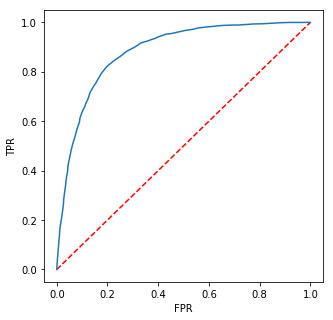

In [62]:
lrModel = model.stages[2]
trainingSummary = lrModel.summary

#obtain the receiver-operating characteristic as dataframe and areaUnderROC
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
plt.plot([0,1], [0,1], 'r--')
plt.plot(trainingSummary.roc.select('FPR').collect(),
        trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [30]:
# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, 
                          classes,
                          normalize = False, 
                          title = "confusion matrix", 
                          cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
        print("Normalize confusion matrix")
    else:
        print("confusion matrix without normalization")
    print(cm)
    
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                horizontalalignment = "center",
                color = "white" if cm[i, j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

    
    

In [57]:
class_temp = predictions.select("label").groupBy("label").count().sort('count', ascending = False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = list(map(str, class_temp))
class_names

['no', 'yes']

In [58]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred, labels = class_names)
cnf_matrix

array([[2024,  360],
       [ 532, 1620]])

confusion matrix without normalization
[[2024  360]
 [ 532 1620]]


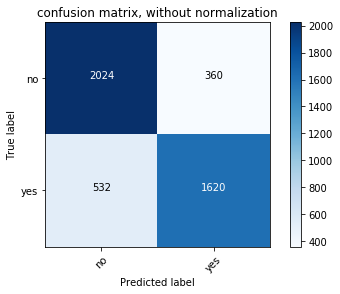

In [59]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names,
                    title = 'confusion matrix, without normalization')
plt.show()

Normalize confusion matrix
[[0.84899329 0.15100671]
 [0.2472119  0.7527881 ]]


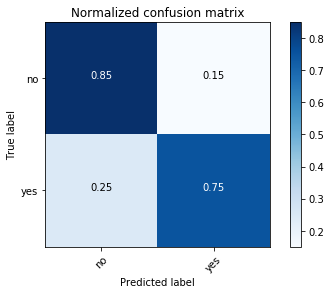

In [60]:
# plot normalized confusion matrix
plt.figure
plot_confusion_matrix(cnf_matrix, classes = class_names,
                     normalize = True,
                     title = "Normalized confusion matrix")
plt.show()